# Project Machine Learning Damiano Ottavi

Dataset import with Pandas

In [2]:
import pandas as pd

df = pd.read_csv(r"C:\Users\ottav\Desktop\Progetti S2I\Machine Learning\Dataset\Kaggle\titanic_sub.csv",
    index_col="PassengerId")

## 1) EDA - Exploratory Data Analysis

During the Exploratory Data Analysis (EDA) phase, the dataset is inspected and cleaned, and initial assumptions and hypotheses are formulated through preliminary analyses. This step is essential to understand the data structure and to support subsequent modeling choices.

In [3]:
df.head()

,Sex,Age,Pclass,Embarked,Survived
PassengerId,,,,,
1,male,22.0,3,S,0
2,female,38.0,1,C,1
3,female,26.0,3,S,1
4,female,35.0,1,S,1
5,male,35.0,3,S,0


From this initial inspection, it emerges that the dataset contains a mix of categorical and numerical features. This implies that categorical variables will need to be encoded into numerical representations in order to be used by machine learning models. The encoding process is addressed in a later stage of the analysis.

In [4]:
print(df.shape, "\n", df.describe())

(891, 5) 
               Age      Pclass    Survived
count  714.000000  891.000000  891.000000
mean    29.699118    2.308642    0.383838
std     14.526497    0.836071    0.486592
min      0.420000    1.000000    0.000000
25%     20.125000    2.000000    0.000000
50%     28.000000    3.000000    0.000000
75%     38.000000    3.000000    1.000000
max     80.000000    3.000000    1.000000


From the output of the describe() function, it can be observed that the Pclass and Survived columns contain no missing values, as their count equals 891, which corresponds to the total number of rows in the dataset.
In contrast, the Age column reports only 714 non-null values, indicating the presence of missing data.

To preserve the overall size of the dataset and avoid losing potentially useful information, missing values in the Age column are imputed in a later stage of the analysis.

To better understand the missing values in Age and potentially in Sex—which was not shown in the previous output—we carry out a more in-depth analysis.

In [5]:
df.Sex.value_counts()  # To check for inconsistencies in the Sex labels (e.g., M, F, etc.) and, if necessary, standardize them.

Sex
male      577
female    314
Name: count, dtype: int64

In [6]:
df.isnull().sum()

Sex           0
Age         177
Pclass        0
Embarked      2
Survived      0
dtype: int64

As mentioned, the Age column contains several missing values, specifically 177. Additionally, the Embarked column also has missing values, in this case 2. 

To better understand the potential impact of these missing values on the overall analysis, we calculate their percentage relative to the total.

In [8]:
print(f"Percentage of missing values in column Age is: {(df.Age.isnull().sum()/df.Age.count()*100).round(2)} %",
      "\n"
    f"Percentage of missing values in columns Embarked is: {(df.Embarked.isnull().sum()/df.Embarked.count()*100).round(2)} %")

Percentage of missing values in column Age is: 24.79 % 
Percentage of missing values in columns Embarked is: 0.22 %


While the percentage of missing values in the Embarked column is negligible (0.22%), the same cannot be said for the Age column, where missing values account for nearly 25%.

In the following steps, we will further analyze the missing values and their potential correlations with the Survived column, which, as will be shown later, will serve as the model’s target

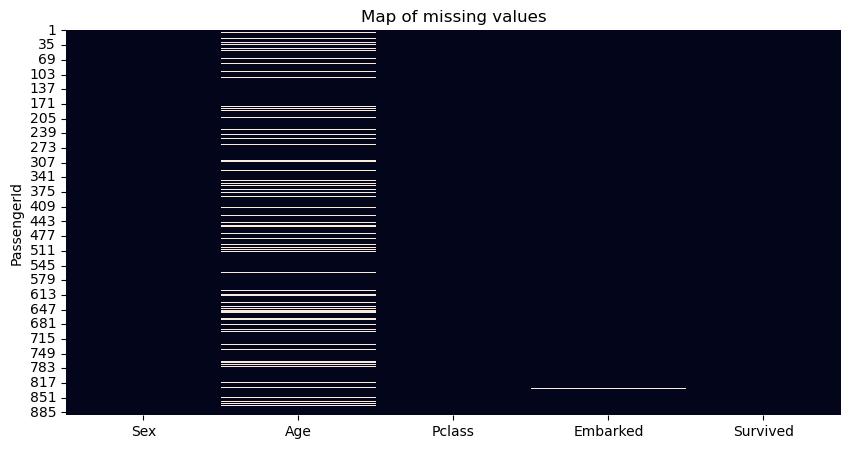

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 5))
sns.heatmap(df.isnull(), cbar = False)
plt.title("Map of missing values")
plt.show()

The above chart shows that the missing values in Age are distributed quite randomly. Therefore, no specific pattern is observed.

In [8]:
df.groupby("Survived")["Age"].apply(lambda x: x.isnull().mean()*100)

Survived
0    22.768670
1    15.204678
Name: Age, dtype: float64

In [10]:
df["Age"].corr(df["Survived"])

-0.07722109457217764

From this result, the correlation between Age and Survived appears to be almost negligible, suggesting a slight tendency for older passengers not to survive. However, overall, the correlation seems too weak to be significant.

We proceed with a more detailed analysis by visualizing the age distribution for both survivors and non-survivors

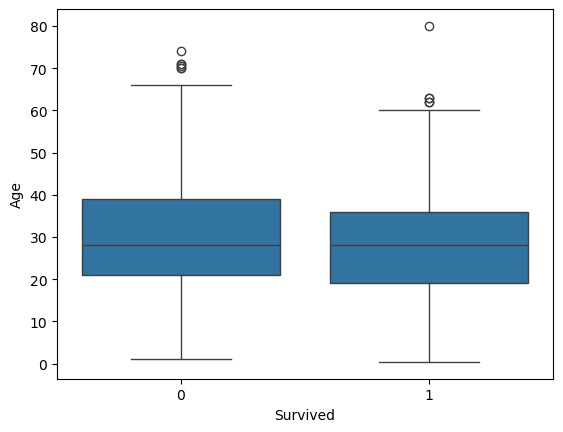

In [11]:
sns.boxplot(x = 'Survived', y = 'Age', data = df)
plt.show()

The boxplot shows that the age distribution for survivors and non-survivors is very similar, with close medians and almost overlapping ranges. This suggests that the Age variable has little discriminative power regarding survival, confirming the low correlation observed (−0.07).

Age exhibits a very weak correlation with the target variable and a similar distribution across classes. Considering the high number of missing values, removing it reduces the risk of introducing noise without significantly affecting model performance.

To test this, two baseline models will be built to evaluate the actual impact of dropping the Age column, comparing the accuracy of the baseline that includes Age with the one that does not.

As a first step, the baseline is constructed without Age.

## 1.2) Dataset preparation

In [12]:
X = df.drop("Survived", axis = 1)
y = df["Survived"]

from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

The splitting of X and y and the train-test split should be performed before building and comparing the baselines, ensuring a consistent and fair comparison.

## 1.3) Baseline 1 - The whole column Age rows with missing valued of Embarked are deleted

In [13]:
X_train_b1 = X_train_full.drop("Age", axis=1).dropna()
X_test_b1 = X_test.drop("Age", axis=1).dropna()

y_train_b1 = y_train_full.loc[X_train_b1.index]
y_test_b1 = y_test.loc[X_test_b1.index]

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#columns definition
cat_feat = ["Sex", "Embarked"]
num_feat = ["Pclass"]

#creation of ColumnTransformer
preprocessor = ColumnTransformer(
                transformers = [("cat", OneHotEncoder(sparse_output = False), cat_feat)],
                remainder = "passthrough",)

#fit only on train
preprocessor.fit(X_train_b1)

#Transformation on train and test
X_train_b1_trans = preprocessor.transform(X_train_b1)
X_test_b1_trans = preprocessor.transform(X_test_b1)

#Use of names from final features
feature_names = (
        list(
            preprocessor.named_transformers_["cat"].get_feature_names_out(
                    cat_feat)
        ) + num_feat)

#Final DFs creation
X_train_b1 = pd.DataFrame(
            X_train_b1_trans, columns = feature_names, index = X_train_b1.index)
X_test_b1 = pd.DataFrame(
            X_test_b1_trans, columns = feature_names, index = X_test_b1.index)

#check
print(X_train_b1.head(), X_test_b1.head())

             Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass
PassengerId                                                                  
299                 0.0       1.0         0.0         0.0         1.0     1.0
885                 0.0       1.0         0.0         0.0         1.0     3.0
248                 1.0       0.0         0.0         0.0         1.0     2.0
479                 0.0       1.0         0.0         0.0         1.0     3.0
306                 0.0       1.0         0.0         0.0         1.0     1.0              Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Pclass
PassengerId                                                                  
710                 0.0       1.0         1.0         0.0         0.0     3.0
440                 0.0       1.0         0.0         0.0         1.0     2.0
841                 0.0       1.0         0.0         0.0         1.0     3.0
721                 1.0       0.0         0.0         0.0       

Now that the data has been preprocessed, we proceed to create the first baseline using a simple model: Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#baseline 1
lr = LogisticRegression()
lr.fit(X_train_b1, y_train_b1)

pred = lr.predict(X_test_b1)
acc_b1 = accuracy_score(y_test_b1, pred)

print(acc_b1)

0.757847533632287


## 1.4) Baseline 2 - Age and Embarked columns are deleted

In [16]:
X_train_b2 = X_train_full.drop(["Age", "Embarked"], axis=1).dropna()
X_test_b2 = X_test.drop("Age", axis=1).dropna()

y_train_b2 = y_train_full.loc[X_train_b2.index]
y_test_b2 = y_test.loc[X_test_b2.index]

In [17]:
#columns definition
cat_feat = ["Sex"]
num_feat = ["Pclass"]

#creation of ColumnTransformer
preprocessor = ColumnTransformer(
                transformers = [("cat", OneHotEncoder(sparse_output = False), cat_feat)],
                remainder = "passthrough",)

#fit only on train
preprocessor.fit(X_train_b2)

#Transformation on train and test
X_train_b2_trans = preprocessor.transform(X_train_b2)
X_test_b2_trans = preprocessor.transform(X_test_b2)

#Use of names from final features
feature_names = (
        list(
            preprocessor.named_transformers_["cat"].get_feature_names_out(
                    cat_feat)
        ) + num_feat)

#final DFs creation
X_train_b2 = pd.DataFrame(
            X_train_b2_trans, columns = feature_names, index = X_train_b2.index)
X_test_b2 = pd.DataFrame(
            X_test_b2_trans, columns = feature_names, index = X_test_b2.index)

#check
print(X_train_b2.head(), X_test_b2.head())

             Sex_female  Sex_male  Pclass
PassengerId                              
299                 0.0       1.0     1.0
885                 0.0       1.0     3.0
248                 1.0       0.0     2.0
479                 0.0       1.0     3.0
306                 0.0       1.0     1.0              Sex_female  Sex_male  Pclass
PassengerId                              
710                 0.0       1.0     3.0
440                 0.0       1.0     2.0
841                 0.0       1.0     3.0
721                 1.0       0.0     2.0
40                  1.0       0.0     3.0


In [18]:
#baseline 2
lr = LogisticRegression()
lr.fit(X_train_b2, y_train_b2)

pred = lr.predict(X_test_b2)
acc_b2 = accuracy_score(y_test_b2, pred)

print(acc_b2)

0.7847533632286996


## 1.5) Baseline 3 - Rows with missing values from Age and Embarked columns are deleted

For baseline 3, we decided to keep both the Age and Embarked columns. Therefore, it is necessary to determine how to handle the missing values.

As a first test, we chose to remove the rows containing missing values in Age and Embarked

In [19]:
X_train_b3 = X_train_full.dropna()
X_test_b3 = X_test.dropna()

y_train_b3 = y_train_full.loc[X_train_b3.index]
y_test_b3 = y_test.loc[X_test_b3.index]

In [20]:
#columns definition
cat_feat = ["Sex", "Embarked"]
num_feat = ["Age", "Pclass"]

#creation of ColumnTransformer
preprocessor = ColumnTransformer(
                transformers = [("cat", OneHotEncoder(sparse_output = False), cat_feat)],
                remainder = "passthrough",)

#fit only on train
preprocessor.fit(X_train_b3)

#Transformation on train and test
X_train_b3_trans = preprocessor.transform(X_train_b3)
X_test_b3_trans = preprocessor.transform(X_test_b3)

#Use of names from final features
feature_names = (
        list(
            preprocessor.named_transformers_["cat"].get_feature_names_out(
                    cat_feat)
        ) + num_feat)

#creation of final DFs
X_train_b3 = pd.DataFrame(
            X_train_b3_trans, columns = feature_names, index = X_train_b3.index)
X_test_b3 = pd.DataFrame(
            X_test_b3_trans, columns = feature_names, index = X_test_b3.index)

#check
print(X_train_b3.head(), X_test_b3.head())

             Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S    Age  \
PassengerId                                                                    
885                 0.0       1.0         0.0         0.0         1.0  25.00   
248                 1.0       0.0         0.0         0.0         1.0  24.00   
479                 0.0       1.0         0.0         0.0         1.0  22.00   
306                 0.0       1.0         0.0         0.0         1.0   0.92   
317                 1.0       0.0         0.0         0.0         1.0  24.00   

             Pclass  
PassengerId          
885             3.0  
248             2.0  
479             3.0  
306             1.0  
317             2.0                Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S   Age  \
PassengerId                                                                   
440                 0.0       1.0         0.0         0.0         1.0  31.0   
841                 0.0       1.0         0.0   

In [21]:
#baseline 3
lr = LogisticRegression()
lr.fit(X_train_b3, y_train_b3)

pred = lr.predict(X_test_b3)
acc_b3 = accuracy_score(y_test_b3, pred)

print(acc_b3)

0.8033707865168539


## 1.6) Baseline 4 - Imputation rows with missing values of Age and Embarked

Baseline 4 will also retain both the Age and Embarked columns, similar to baseline 3, but missing values will be imputed using various strategies.

In [22]:
X_train_b4 = X_train_full
X_test_b4 = X_test

y_train_b4 = y_train_full
y_test_b4 = y_test

In [23]:
#columns definition
cat_feat = ["Sex", "Embarked"]
num_feat = ["Age", "Pclass"]

#creation of ColumnTransformer
preprocessor = ColumnTransformer(
                transformers = [("cat", OneHotEncoder(sparse_output = False), cat_feat)],
                remainder = "passthrough",)

#fit only on train
preprocessor.fit(X_train_b4)

#Transformation on train and test
X_train_b4_trans = preprocessor.transform(X_train_b4)
X_test_b4_trans = preprocessor.transform(X_test_b4)

#Use of names from final features
feature_names = (
        list(
            preprocessor.named_transformers_["cat"].get_feature_names_out(
                    cat_feat)
        ) + num_feat)

#final DFs creation
X_train_b4 = pd.DataFrame(
            X_train_b4_trans, columns = feature_names, index = X_train_b4.index)
X_test_b4 = pd.DataFrame(
            X_test_b4_trans, columns = feature_names, index = X_test_b4.index)

#check 
print(X_train_b4.head(), X_test_b4.head())

             Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
PassengerId                                                             
299                 0.0       1.0         0.0         0.0         1.0   
885                 0.0       1.0         0.0         0.0         1.0   
248                 1.0       0.0         0.0         0.0         1.0   
479                 0.0       1.0         0.0         0.0         1.0   
306                 0.0       1.0         0.0         0.0         1.0   

             Embarked_nan    Age  Pclass  
PassengerId                               
299                   0.0    NaN     1.0  
885                   0.0  25.00     3.0  
248                   0.0  24.00     2.0  
479                   0.0  22.00     3.0  
306                   0.0   0.92     1.0                Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
PassengerId                                                             
710                 0.0       1.0        

Now that the dataframe has been split and all columns have been converted to numeric, we can proceed with imputing the missing values.

Missing values can be imputed by calculating the median or mean on the training set and applying it to the test set, thus avoiding data leakage. The mode is excluded a priori, as it is mainly used for categorical values.

Regarding the choice between mean and median, we will determine which one yields better accuracy.

### Imputation of missing values using the median

In [24]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

imputer.fit(X_train_b4)
X_train_b4_imputed = imputer.transform(X_train_b4)
X_test_b4_imputed = imputer.transform(X_test_b4)


X_train0_median = pd.DataFrame(
    X_train_b4_imputed, columns=X_train_b4.columns, index=X_train_b4.index
)
X_test_median = pd.DataFrame(
    X_test_b4_imputed, columns=X_test_b4.columns, index=X_test_b4.index
)

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Model definition
dtc = DecisionTreeClassifier(random_state=42)

# Values to be tested
param_grid = {"max_depth": [2, 5, 10, 25, None]}

# GridSearch with k-fold cross validation (k=5)
grid = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    cv=5,  # number of folds
    scoring="accuracy",
    n_jobs=-1,
)

# train on coded X_train0, therefore X_train0_df and y_train0
grid.fit(X_train0_median, y_train_b4)

best_depth = grid.best_params_["max_depth"]

print(f"Best max_depth: {grid.best_params_['max_depth']}")
print(f"Average accuracy CV: {grid.best_score_:.4f}")

Best max_depth: 5
Average accuracy CV: 0.8039


### Imputation of missing values using the mean

In [27]:
imputer = SimpleImputer(strategy="mean")

imputer.fit(X_train_b4)
X_train_b4_imputed = imputer.transform(X_train_b4)
X_test_b4_imputed = imputer.transform(X_test_b4)


X_train0_mean = pd.DataFrame(
    X_train_b4_imputed, columns=X_train_b4.columns, index=X_train_b4.index
)
X_test_mean = pd.DataFrame(
    X_test_b4_imputed, columns=X_test_b4.columns, index=X_test_b4.index
)

In [28]:
# Model definition
dtc = DecisionTreeClassifier(random_state=42)

#values to be tested
param_grid = {"max_depth": [2, 5, 10, 25, None]}

# GridSearch with k-fold cross validation (k=5)
grid = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    cv=5,  # number of folds
    scoring="accuracy",
    n_jobs=-1,
)

# train on coded X_train0, therefore X_train0_df and y_train0
grid.fit(X_train0_mean, y_train_b4)

best_depth = grid.best_params_["max_depth"]

print(f"Best max_depth: {grid.best_params_['max_depth']}")
print(f"Average accuracy CV: {grid.best_score_:.4f}")

Best max_depth: 10
Average accuracy CV: 0.7980


The comparison shows that imputing missing values using the median provides better accuracy in a decision tree model.

Now, to allow a fair comparison with the other baselines, baseline 4 is built using Logistic Regression.

In [29]:
#baseline 4
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train0_mean, y_train_b4)

pred = lr.predict(X_test_mean)
acc_b4 = accuracy_score(y_test_b4, pred)

print(acc_b4)

0.7847533632286996


## 1.7) Comparion between the four baselines

In [30]:
print(f"Accuracy of baseline 1: {acc_b1.round(4)}") 
print(f"Accuracy of baseline 2: {acc_b2.round(4)}")
print(f"Accuracy of baseline 3: {acc_b3.round(4)}")
print(f"Accuracy of baseline 4: {acc_b4.round(4)}")

Accuracy of baseline 1: 0.7578
Accuracy of baseline 2: 0.7848
Accuracy of baseline 3: 0.8034
Accuracy of baseline 4: 0.7848


The comparison shows that baseline 3 achieves the highest accuracy, so the final model will be built using this setup, i.e., by removing the rows with missing values in Age and Embarked.

## 1.8) EDA - Exploratory Data Analysis part 2

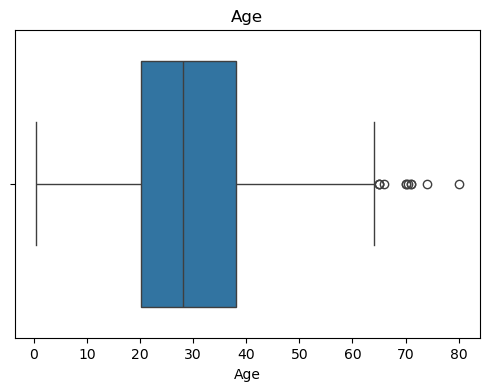

In [32]:
# check outliers

plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Age"])
plt.title("Age")

plt.show()

The boxplot above shows that there are a few values above 70 years, but since they are still valid data points, they should not be removed

<Axes: xlabel='Sex', ylabel='Survived'>

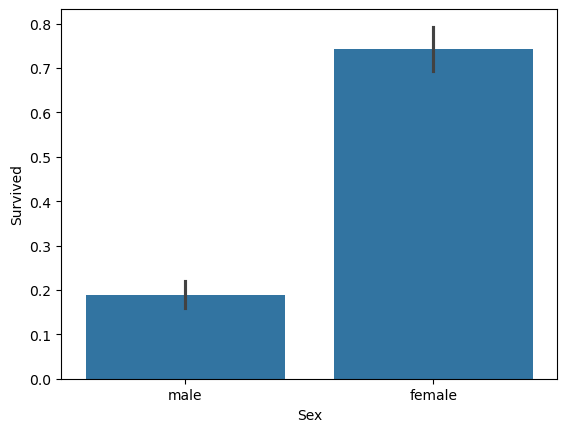

In [33]:
sns.barplot(x="Sex", y="Survived", data=df)

Even from this simple bar plot, it is apparent that the majority of survivors are female.

In [34]:
df.groupby("Survived")["Sex"].value_counts(normalize=True).loc[
    1
] * 100  # percentage of female and male survivors

Sex
female    68.128655
male      31.871345
Name: proportion, dtype: float64

<Axes: xlabel='Pclass', ylabel='Survived'>

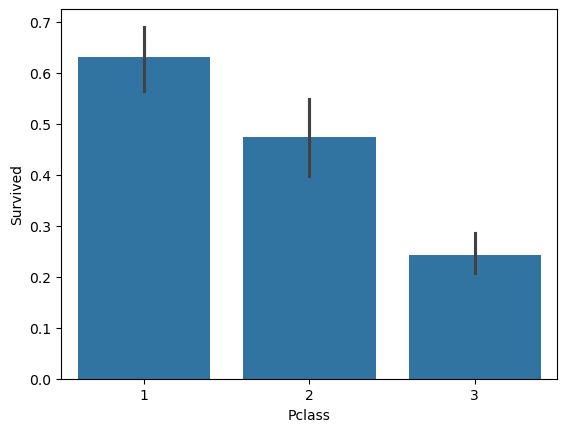

In [35]:
# check Pclass

sns.barplot(x="Pclass", y="Survived", data=df)

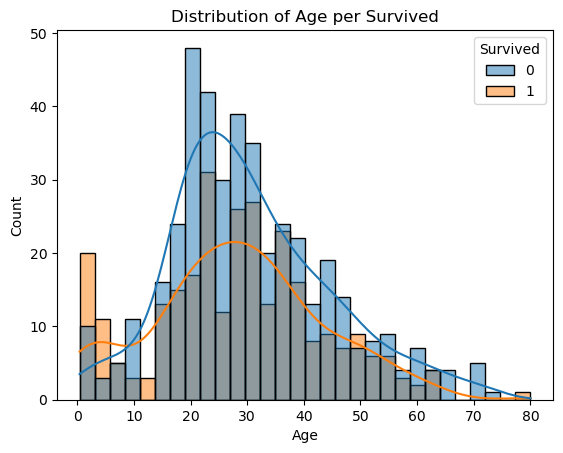

In [36]:
sns.histplot(data=df, x="Age", hue="Survived", kde=True, bins=30)
plt.title("Distribution of Age per Survived")
plt.show()

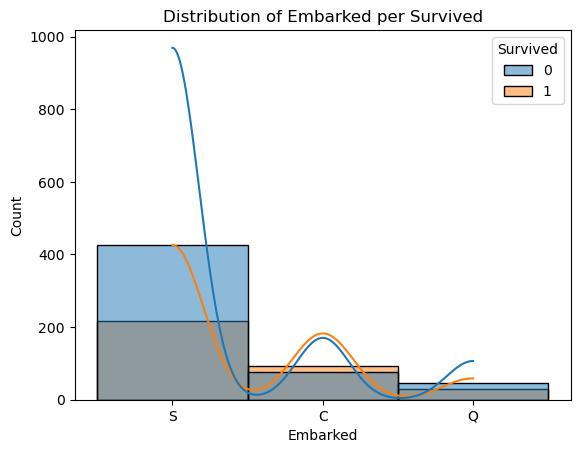

In [37]:
sns.histplot(data=df, x="Embarked", hue="Survived", kde=True, bins=30)
plt.title("Distribution of Embarked per Survived")
plt.show()

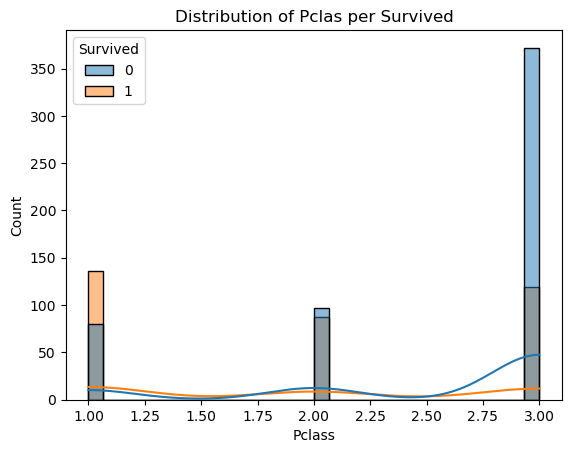

In [38]:
sns.histplot(data=df, x="Pclass", hue="Survived", kde=True, bins=30)
plt.title("Distribution of Pclas per Survived")
plt.show()

## 2) Decision tree final model construction

The study of the four baselines revealed that the model built by removing rows with missing values achieves the highest accuracy. Therefore, the final Decision Tree model will be created based on the same approach.

### 2.2) Model Validation using different layers of depth

In [39]:
# model definition
dtc = DecisionTreeClassifier(random_state=0)

# values to be tested
param_grid = {"max_depth": [2, 5, 10, 25, None]}

# GridSearch with k-fold cross validation (k=5)
grid = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    cv=5,  # number of folds
    scoring="accuracy",
    n_jobs=-1,
)

# train on coded X_train
grid.fit(X_train_b3, y_train_b3)

best_depth = grid.best_params_["max_depth"]

print(f"Best max_depth: {grid.best_params_['max_depth']}")
print(f"Average accuracy CV: {grid.best_score_:.4f}")

Best max_depth: 2
Average accuracy CV: 0.7978


GridSearchCV was used to optimize the max_depth parameter, as it primarily controls the balance between underfitting (trees that are too simple) and overfitting (trees that are too complex)

### 2.3) Final model witch selected depth

In [40]:
dtc_entropy = DecisionTreeClassifier(
    criterion="entropy", max_depth=best_depth, random_state=42
)  # Entropy criterion

dtc_entropy.fit(X_train_b3, y_train_b3)
y_pred = dtc_entropy.predict(X_test_b3)

acc_entropy = accuracy_score(y_test_b3, y_pred)
print(acc_entropy)

0.7865168539325843


In [41]:
dtc_gini = DecisionTreeClassifier(
    criterion="gini", max_depth=best_depth, random_state=42
)  # Gini criterion

dtc_gini.fit(X_train_b3, y_train_b3)
y_pred = dtc_gini.predict(X_test_b3)

acc_gini = accuracy_score(y_test_b3, y_pred)
print(acc_gini)

0.7865168539325843


### 2.4) Comparison between the final model and the baseline 3

In [42]:
print(
    "Baseline model accuracy is {:.4f}, while the final model accuracy is {:.4f}.".format(
        acc_b3, acc_gini)
    )

Baseline model accuracy is 0.8034, while the final model accuracy is 0.7865.


The final Decision Tree model achieves slightly lower accuracy than the baseline (Logistic Regression), indicating that for a small dataset, a simple model like Logistic Regression may be more suitable. Among the splitting criteria, Gini produced results identical to Entropy

### 2.5) Decision Tree visualisation

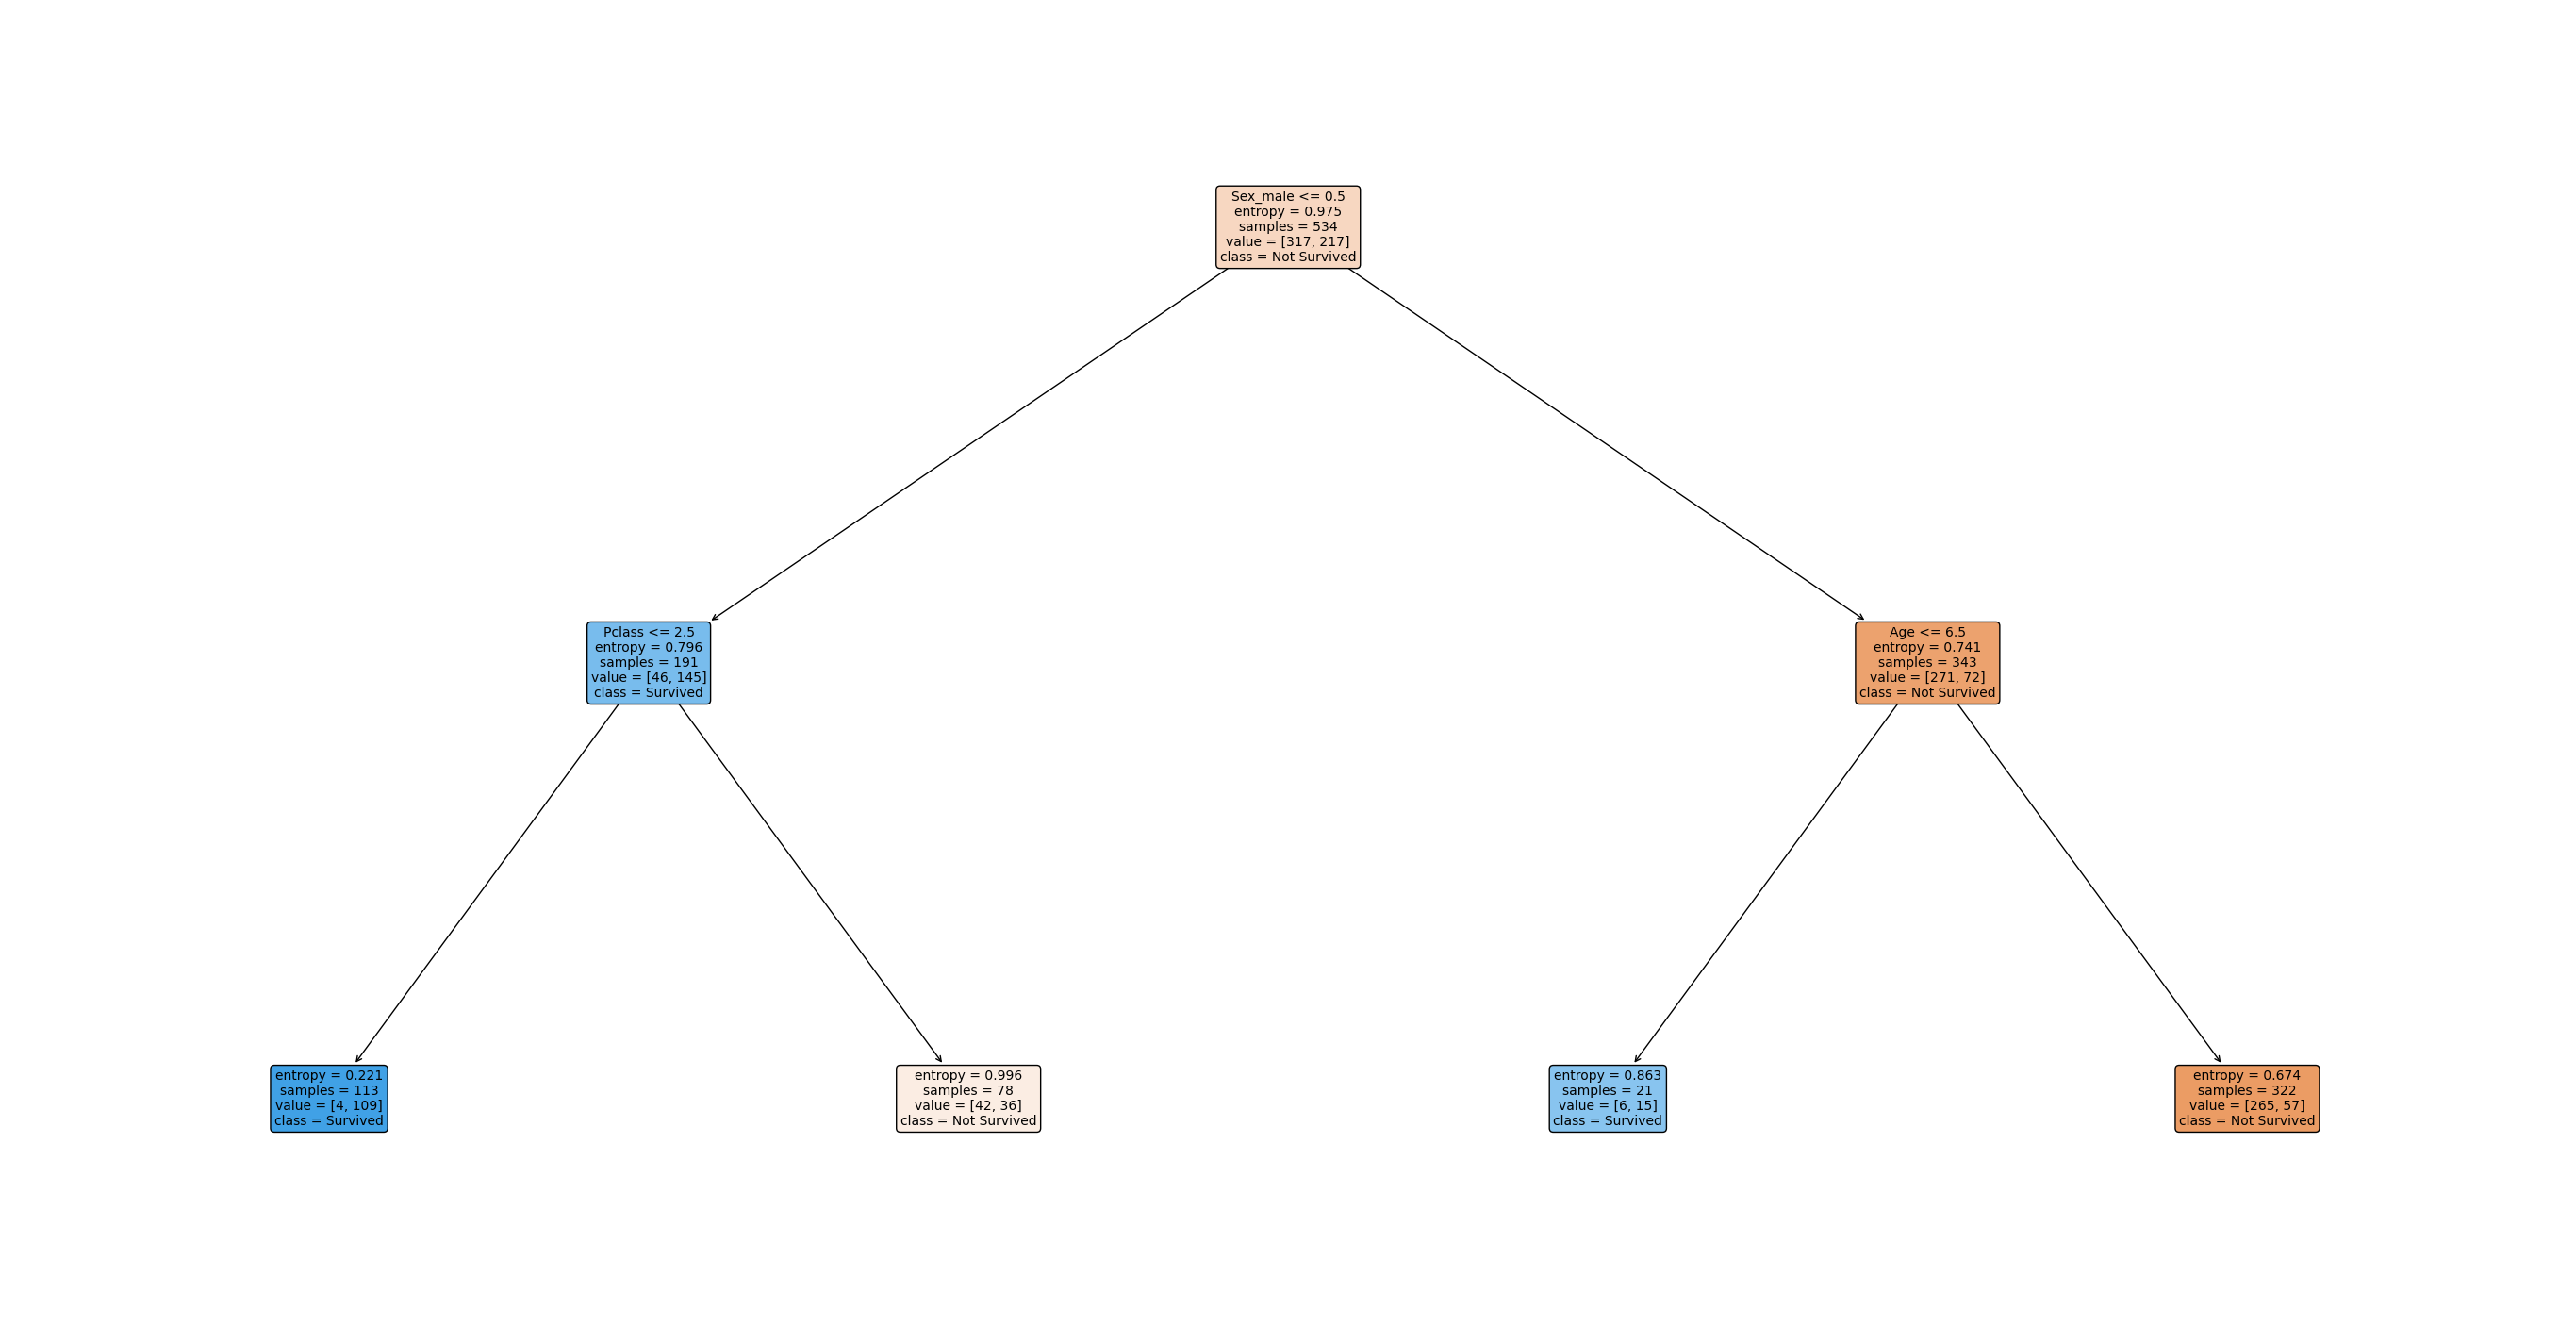

In [43]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(35, 18))
tree.plot_tree(
    dtc_entropy,
    feature_names=X_train_b3.columns,
    class_names=["Not Survived", "Survived"],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.show()

In [44]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64